<center>
<img src="../../img/ml_theme.png">
# Дополнительное профессиональное <br> образование НИУ ВШЭ
#### Программа "Практический анализ данных и машинное обучение"
<img src="../../img/faculty_logo.jpg" height="240" width="240">
## Автор материала: преподаватель Факультета Компьютерных Наук ВШЭ <br> Кашницкий Юрий
</center>
Материал распространяется на условиях лицензии <a href="https://opensource.org/licenses/MS-RL">Ms-RL</a>. Можно использовать в любых целях, кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Занятие 3. Обучение с учителем. Методы классификации
## <center>Часть 4.  Извлечение признаков. Практика с набором данных Titanic

**Рассмотрим пример создания признаков с [набором данных](https://www.kaggle.com/c/titanic) "Titanic".**

In [31]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
%pylab inline
import seaborn as sns
figsize(12, 8)

Populating the interactive namespace from numpy and matplotlib


**Функция для формирования csv-файла посылки на Kaggle**

In [32]:
def write_to_submission_file(predicted_labels, out_file, train_num=891,
                    target='Survived', index_label="PassengerId"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(train_num + 1,
                                                  train_num + 1 +
                                                  predicted_labels.shape[0]),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

**Считываем обучающую и тестовую выборки**

In [33]:
train_df = pd.read_csv("../../data/titanic_train.csv") 
test_df = pd.read_csv("../../data/titanic_test.csv") 

In [34]:
y = train_df['Survived']

In [35]:
train_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [36]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [37]:
test_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


Заполним пропуски медианными значениями

In [38]:
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].median())
test_df['Age'] = test_df['Age'].fillna(test_df['Age'].median())

**Кодируем категориальный признак "Sex"**

In [39]:
sex_encoder = LabelEncoder()
sex_encoder.fit(train_df['Sex'])

LabelEncoder()

**Составим обучающую и тестовую выборки**

In [40]:
X_train = train_df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch']]
X_train['Sex'] = sex_encoder.fit_transform(X_train['Sex'])
X_train.head()

,Pclass,Sex,Age,SibSp,Parch
0,3,1,22.0,1,0
1,1,0,38.0,1,0
2,3,0,26.0,0,0
3,1,0,35.0,1,0
4,3,1,35.0,0,0


In [41]:
X_test = test_df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch']]
X_test['Sex'] = sex_encoder.fit_transform(X_test['Sex'])
X_test.head()

,Pclass,Sex,Age,SibSp,Parch
0,3,1,34.5,0,0
1,3,0,47.0,1,0
2,2,1,62.0,0,0
3,3,1,27.0,0,0
4,3,0,22.0,1,1


In [42]:
y = train_df['Survived']
y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [43]:
# parameter combinations to try
forest_params = {'criterion': ('gini', 'entropy'),
                     'n_estimators': [50, 100],
                     'max_depth': [2, 3, 4],
                     'min_samples_leaf': [2, 3, 4]}

locally_best_forest = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1),
                                     forest_params,
                                     verbose=True, n_jobs=-1, cv=5)
locally_best_forest.fit(X_train, y)

print("Best params:", locally_best_forest.best_params_)
print("Best cross validaton score", locally_best_forest.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   22.6s finished


Best params: {'min_samples_leaf': 2, 'n_estimators': 100, 'criterion': 'gini', 'max_depth': 4}
Best cross validaton score 0.828282828283


**Эта посылка получила на Kaggle 0.76555**

In [44]:
predicted_labels = locally_best_forest.best_estimator_.predict(X_test)

In [45]:
write_to_submission_file(predicted_labels, '../../output/titanic_rf.csv')

**Теперь можно настроить параметры поточнее. Но сначала посмотрим, как можно добавить признак "Title", "вытащив" его из имени.** 

In [46]:
def parse_title(name):
    """
    Takes name in a form "Lastname, title. name"
    and returns title
    """
    return name.split(',')[1].split('.')[0].strip()

train_df['Title'] = [parse_title(name) for name in train_df['Name']]
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


**Распределение признака "Title"**

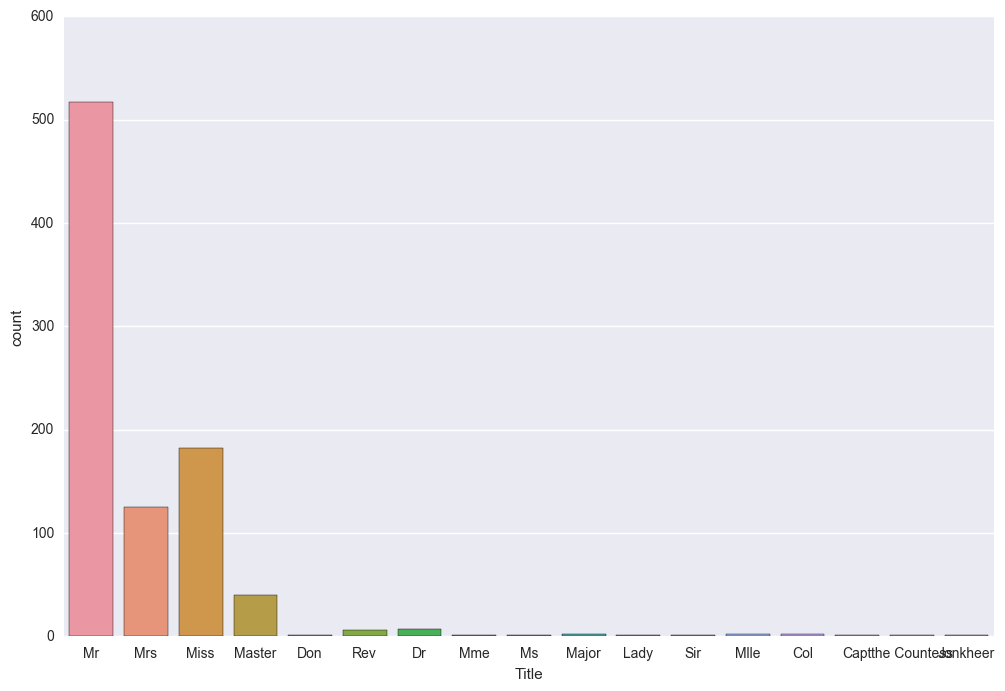

In [47]:
sns.countplot(train_df['Title'])

In [48]:
titles = train_df['Title'].value_counts()
titles

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Col               2
Major             2
the Countess      1
Lady              1
Ms                1
Don               1
Jonkheer          1
Capt              1
Mme               1
Sir               1
Name: Title, dtype: int64

**Посмотрим на имя, пол и возраст пассажиров с редкими обращениями**

In [49]:
rare_titles = titles[titles < 10]
criterion = train_df['Title'].map(lambda title: 
                                  title in rare_titles.index)
train_df[criterion][['Name', 'Sex', 'Age', 'Title']].sort_values(by='Title')

,Name,Sex,Age,Title
745,"Crosby, Capt. Edward Gifford",male,70.0,Capt
694,"Weir, Col. John",male,60.0,Col
647,"Simonius-Blumer, Col. Oberst Alfons",male,56.0,Col
30,"Uruchurtu, Don. Manuel E",male,40.0,Don
766,"Brewe, Dr. Arthur Jackson",male,28.0,Dr
317,"Moraweck, Dr. Ernest",male,54.0,Dr
398,"Pain, Dr. Alfred",male,23.0,Dr
660,"Frauenthal, Dr. Henry William",male,50.0,Dr
796,"Leader, Dr. Alice (Farnham)",female,49.0,Dr
632,"Stahelin-Maeglin, Dr. Max",male,32.0,Dr


**Посмотрим распределение возрастов в зависимости от обращения**

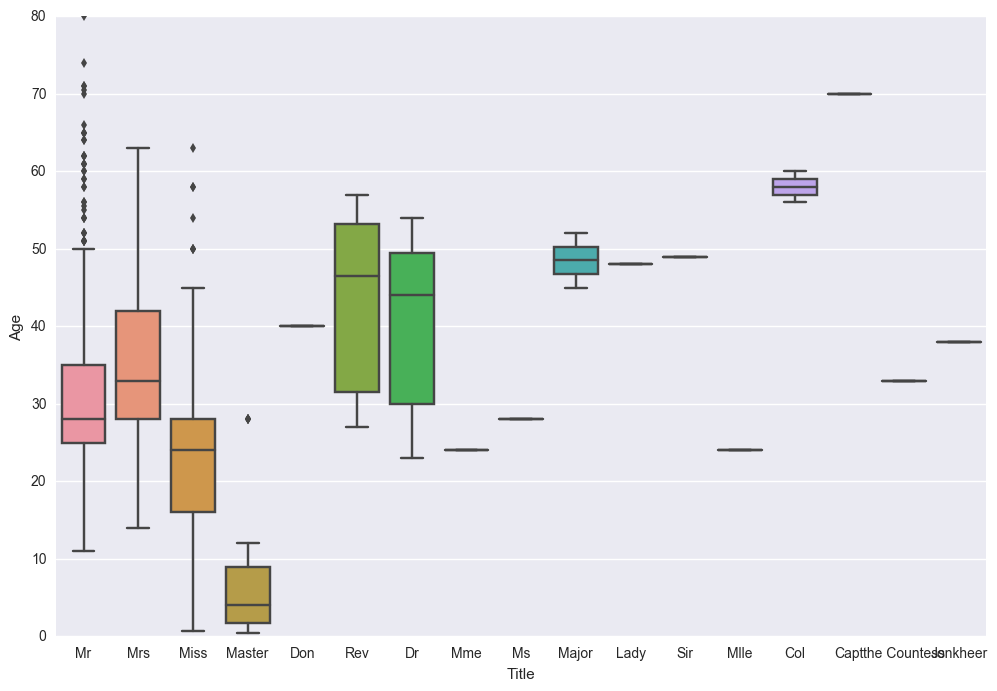

In [50]:
sns.boxplot(x="Title", y='Age', data=train_df)

**Объединим редкие "Capt", "Sir", "Don", "Col", "Major", "Rev", "Jonkheer" и "Dr" c "Mr", а "the Countess", "Mlle", "Lady" и "Ms" - c "Mrs".**

In [51]:
def merge_titles(title):
    if title in ("Capt", "Sir", "Don", 
                "Col", "Major", "Rev", 
                "Jonkheer","Dr"):
        return "Mr"
    elif title in ("the Countess", "Mlle", "Mme", "Lady", "Ms"):
        return "Mrs"
    else:
        return title

train_df['Title'] = train_df['Title'].map(merge_titles)
train_df['Title'].value_counts()

Mr        538
Miss      182
Mrs       131
Master     40
Name: Title, dtype: int64

**Выделяются возрастные группы по обращениям "Master" и "Miss". Чуть менее видна разница между "Mr" и "Mrs".**

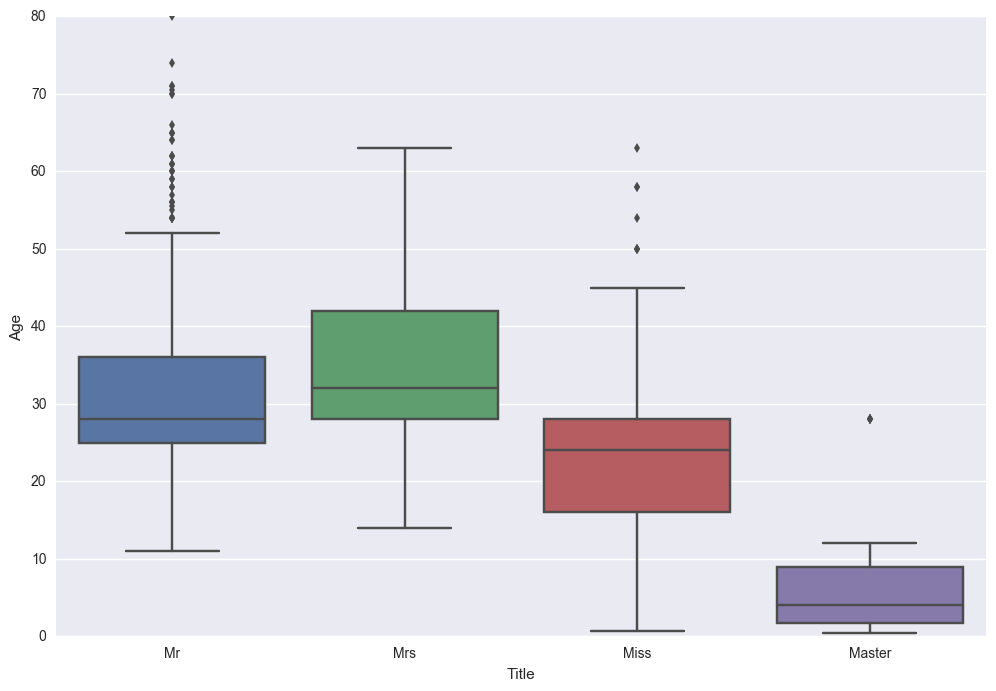

In [52]:
sns.boxplot(x="Title", y='Age', data=train_df)

**Составим выборки с признаком "Title" вместо "Age"**

In [53]:
X_train.head(2)

,Pclass,Sex,Age,SibSp,Parch
0,3,1,22.0,1,0
1,1,0,38.0,1,0


In [54]:
train_df['Title'] = train_df['Name'].map(parse_title)\
                                    .map(merge_titles)
test_df['Title'] = test_df['Name'].map(parse_title)\
                                    .map(merge_titles)
# encode categorical 'Title'
title_encoder = LabelEncoder()
# scikit's bug. If there is a new label in a test set, encoder
# doesn't know what to do with it
title_encoder.fit(train_df['Title'].append(test_df['Title']))

X_train['Title'] = title_encoder.transform(train_df['Name']
                                           .map(parse_title)
                                           .map(merge_titles))
X_test['Title'] = title_encoder.transform(test_df['Name']
                                          .map(parse_title)
                                          .map(merge_titles))

**Удалим из обучающей и тестовой выборок признак "Age" и посмотрим на выборки перед обучением случайного леса.**

In [55]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Title
0,3,1,22.0,1,0,3
1,1,0,38.0,1,0,4
2,3,0,26.0,0,0,2
3,1,0,35.0,1,0,4
4,3,1,35.0,0,0,3


In [56]:
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Title
0,3,1,34.5,0,0,3
1,3,0,47.0,1,0,4
2,2,1,62.0,0,0,3
3,3,1,27.0,0,0,3
4,3,0,22.0,1,1,4


**Для сравнения выберем те же параметры случайного леса, что и в предыдущем случае**

In [57]:
# parameter combinations to try
forest_params = {'criterion': ('gini', 'entropy'),
                     'n_estimators': [50, 100],
                     'max_depth': [2, 3, 4],
                     'min_samples_leaf': [2, 3, 4]}

locally_best_forest = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1),
                                     forest_params,
                                     verbose=True, n_jobs=-1, cv=5)
locally_best_forest.fit(X_train, y)

print("Best params:", locally_best_forest.best_params_)
print("Best cross validaton score", locally_best_forest.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   22.6s finished


Best params: {'min_samples_leaf': 3, 'n_estimators': 50, 'criterion': 'entropy', 'max_depth': 4}
Best cross validaton score 0.833894500561


**Эта посылка получила на Kaggle 0.78469**

In [58]:
predicted_labels = locally_best_forest.best_estimator_.predict(X_test)

In [59]:
write_to_submission_file(predicted_labels, '../../output/titanic_rf_with_title.csv')

## Ссылки

- [Соревнование](https://www.kaggle.com/c/titanic) Kaggle "Titanic: Machine Learning from a Disaster"
- <a href="https://www.dataquest.io/mission/74/getting-started-with-kaggle/">Тьюториал</a> Dataquest по задаче Kaggle "Titanic: Machine Learning from Disaster"